# Description

The purpose of this notebook is to learn about Transfer learning based on the Resnet architectures.

# Tasks

In [1]:
import random
import numpy as np
import time

import torch
import torchvision.datasets
from torchvision.models import resnet18

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline  

import warnings
warnings.filterwarnings("ignore")

Task 1. Compare the accuracy of the models: model from the previous notebook and the Resnet18 model.

__Data preparation__

In [2]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [4]:
X_train /= 255.
X_test /= 255.

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

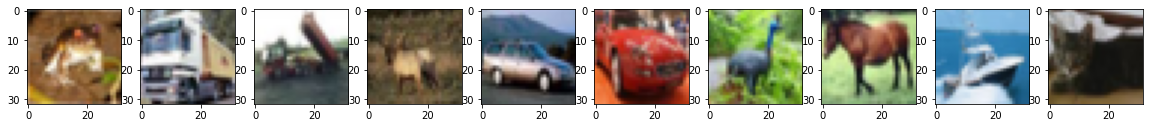

In [5]:
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [6]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

__Training process__

In [7]:
def train(net, X_train, y_train, X_test, y_test, batch_size=256, epoch_num=50, epoch_info_show=10,
          weight_decay=0, save_net_state=False, verbose=True):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, weight_decay=weight_decay)

    t = time.time()
    test_accuracy_history = []
    test_loss_history = []
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(1, epoch_num+1):
        order = np.random.permutation(len(X_train))

        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
            
            preds = net.forward(X_batch)
            
            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
      
        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            loss_value = loss(test_preds, y_test).item()
            test_loss_history.append(loss_value)

            accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
            test_accuracy_history.append(accuracy)
        
            if verbose:
                if epoch % epoch_info_show == 0:
                    if device.type == 'cuda':
                            print('Train Epoch: {} Time: {} Accuracy: {}, GPU_Mem_alloc: {} GPU_Mem_cashed: {}'.format(
                            epoch, time.strftime("%H:%M:%S", time.gmtime(time.time() - t)), 
                            accuracy, torch.cuda.memory_allocated(),torch.cuda.memory_cached()))      
                    else:
                        print('Train Epoch: {} Time: {} Accuracy: {}'.format(epoch, 
                            time.strftime("%H:%M:%S", time.gmtime(time.time() - t)), accuracy))

    net_state = net.state_dict()
    del net

    if save_net_state:
        return test_accuracy_history, test_loss_history, net_state
    else:
        return test_accuracy_history, test_loss_history

In [8]:
# add two dicts for saving information about models work
accuracies = {}
losses = {}

__Plotting graphs__

In [9]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(15, 6)})

def acc_loss_graph(accuracies, losses, net_list, save_file_name='plot.png', download=False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    for experiment_id in net_list:
        ax1.plot(accuracies[experiment_id], label=experiment_id)
    
    ax1.legend()
    ax1.set_title('Validation Accuracy')
    fig.tight_layout()

    for experiment_id in net_list:
        ax2.plot(losses[experiment_id], label=experiment_id)
    
    ax2.legend()
    ax2.set_title('Validation Loss');

    fig.tight_layout()
    
    if download:
        fig.savefig(save_file_name)

__Initializing the model from the previous notebook__

In [10]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)
        
        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1 = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2 = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)

        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3 = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.fc1 = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4 = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)

        self.fc2 = torch.nn.Linear(256, 64)
        self.act5 = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = self.batch_norm0(x)
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)

        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)
        return x

__Training models__

In [11]:
# Training CIFARNet model 
accuracies['cifar_net'], losses['cifar_net'] = train(CIFARNet(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:00:20 Accuracy: 0.7020999789237976, GPU_Mem_alloc: 142680064 GPU_Mem_cashed: 1866465280
Train Epoch: 20 Time: 00:00:41 Accuracy: 0.7069999575614929, GPU_Mem_alloc: 142680064 GPU_Mem_cashed: 1866465280
Train Epoch: 30 Time: 00:01:01 Accuracy: 0.6987999677658081, GPU_Mem_alloc: 142680064 GPU_Mem_cashed: 1866465280
Train Epoch: 40 Time: 00:01:21 Accuracy: 0.7094999551773071, GPU_Mem_alloc: 142680064 GPU_Mem_cashed: 1866465280
Train Epoch: 50 Time: 00:01:42 Accuracy: 0.7105000019073486, GPU_Mem_alloc: 142680064 GPU_Mem_cashed: 1866465280


In [12]:
# Training Resnet18 model
accuracies['resnet18'], losses['resnet18'] = train(resnet18(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:02:40 Accuracy: 0.6837999820709229, GPU_Mem_alloc: 355291648 GPU_Mem_cashed: 4150263808
Train Epoch: 20 Time: 00:05:20 Accuracy: 0.7446999549865723, GPU_Mem_alloc: 355291648 GPU_Mem_cashed: 4150263808
Train Epoch: 30 Time: 00:07:58 Accuracy: 0.7195000052452087, GPU_Mem_alloc: 355291648 GPU_Mem_cashed: 4150263808
Train Epoch: 40 Time: 00:10:37 Accuracy: 0.734499990940094, GPU_Mem_alloc: 355291648 GPU_Mem_cashed: 4150263808
Train Epoch: 50 Time: 00:13:15 Accuracy: 0.7488999962806702, GPU_Mem_alloc: 355291648 GPU_Mem_cashed: 4150263808


Task 2. Implementing the ResNet architecture.

In [13]:
class LambdaLayer(torch.nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    
    def forward(self, x):
        return self.lambd(x)

In [14]:
class BasicBlock(torch.nn.Module):
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1, option='A', 
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(BasicBlock, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.act = torch.nn.ReLU()

        self.conv1 = torch.nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)

        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1,bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.d_out2 = torch.nn.Dropout2d(d_out_p)
        
        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                self.shortcut = LambdaLayer(lambda x: torch.nn.functional.pad(x[:, :, ::2, ::2], \
                (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1,
                stride=stride, bias=False), torch.nn.BatchNorm2d(self.expansion * planes))

    def forward(self, x):
        out = self.conv1(x)
        
        if self.use_batch_norm:
            out = self.bn1(out)
        
        if self.use_drop_out:
            out = self.d_out1(out)
        
        out = self.act(out)
        out = self.conv2(out)
        
        if self.use_batch_norm:
            out = self.bn2(out)

        if self.use_drop_out:
            out = self.d_out2(out)
        
        out += self.shortcut(x)
        out = self.act(out)
        return out

In [15]:
class ResNet(torch.nn.Module):
    
    def __init__(self, block, num_blocks, num_classes=10, 
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(ResNet, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.in_planes = 16
        self.act = torch.nn.ReLU()

        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        
        self.linear = torch.nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride,use_batch_norm=self.use_batch_norm, 
                                use_drop_out=self.use_drop_out,d_out_p=self.d_out_p))
            self.in_planes = planes * block.expansion
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        
        if self.use_batch_norm:
            out = self.bn1(out)
        
        if self.use_drop_out:
            out = self.d_out1(out)

        out = self.act(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.functional.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [16]:
def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])

def resnet110_no_bn():
    return ResNet(BasicBlock, [18, 18, 18], use_batch_norm=False)

def resnet110_d_out15():
    return ResNet(BasicBlock, [18, 18, 18], use_drop_out=True, d_out_p=0.15)

def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])

def resnet20_d_out5():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True)

def resnet20_d_out3(**kwargs):
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.3)

def resnet20_d_out8():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.8)

def resnet20_d_out15():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.15)

__Training model__

In [17]:
# Training Resnet20 model
accuracies['resnet20'], losses['resnet20'] = train(resnet20(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:02:28 Accuracy: 0.7317999601364136, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3776970752
Train Epoch: 20 Time: 00:04:56 Accuracy: 0.7860999703407288, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3776970752
Train Epoch: 30 Time: 00:07:24 Accuracy: 0.7590000033378601, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3776970752
Train Epoch: 40 Time: 00:09:53 Accuracy: 0.776199996471405, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3776970752
Train Epoch: 50 Time: 00:12:21 Accuracy: 0.7989000082015991, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3776970752


__Visualization of training__

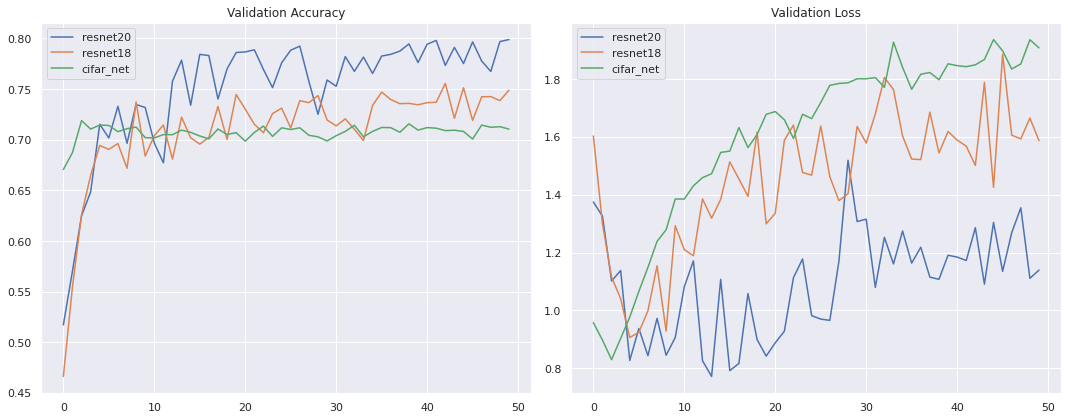

In [18]:
acc_loss_graph(accuracies, losses, ['resnet20', 'resnet18', 'cifar_net'])

Task 3. Evaluate ResNet models training with and without Batch Normalization.

__Training models__

In [19]:
# Training Resnet110 model
accuracies['resnet110'], losses['resnet110'] = train(resnet110(), X_train, y_train, X_test, y_test, batch_size=64)

Train Epoch: 10 Time: 00:15:40 Accuracy: 0.8229999542236328, GPU_Mem_alloc: 152545792 GPU_Mem_cashed: 3934257152
Train Epoch: 20 Time: 00:31:20 Accuracy: 0.8389999866485596, GPU_Mem_alloc: 152545792 GPU_Mem_cashed: 3934257152
Train Epoch: 30 Time: 00:47:00 Accuracy: 0.8246999979019165, GPU_Mem_alloc: 152545792 GPU_Mem_cashed: 3934257152
Train Epoch: 40 Time: 01:02:41 Accuracy: 0.8312000036239624, GPU_Mem_alloc: 152545792 GPU_Mem_cashed: 3934257152
Train Epoch: 50 Time: 01:18:21 Accuracy: 0.8422999978065491, GPU_Mem_alloc: 152545792 GPU_Mem_cashed: 3934257152


In [22]:
# Training Resnet110 model without Batch Normalization
accuracies['resnet110_no_bn'], losses['resnet110_no_bn'] = \
train(resnet110_no_bn(), X_train, y_train, X_test, y_test, batch_size=64)

Train Epoch: 10 Time: 00:12:26 Accuracy: 0.674299955368042, GPU_Mem_alloc: 152210944 GPU_Mem_cashed: 3934257152
Train Epoch: 20 Time: 00:25:16 Accuracy: 0.6740999817848206, GPU_Mem_alloc: 152210944 GPU_Mem_cashed: 3934257152
Train Epoch: 30 Time: 00:38:00 Accuracy: 0.6657999753952026, GPU_Mem_alloc: 152210944 GPU_Mem_cashed: 3934257152
Train Epoch: 40 Time: 00:50:39 Accuracy: 0.6785999536514282, GPU_Mem_alloc: 152210944 GPU_Mem_cashed: 3934257152
Train Epoch: 50 Time: 01:03:16 Accuracy: 0.6507999897003174, GPU_Mem_alloc: 152210944 GPU_Mem_cashed: 3934257152


In [23]:
# Training Resnet20 model with batch size = 64
accuracies['resnet20 bs=64'], losses['resnet20 bs=64'] = \
train(resnet20(), X_train, y_train, X_test, y_test, batch_size=64)

Train Epoch: 10 Time: 00:02:49 Accuracy: 0.7967999577522278, GPU_Mem_alloc: 128814592 GPU_Mem_cashed: 3934257152
Train Epoch: 20 Time: 00:05:33 Accuracy: 0.786799967288971, GPU_Mem_alloc: 128814592 GPU_Mem_cashed: 3934257152
Train Epoch: 30 Time: 00:08:13 Accuracy: 0.8104000091552734, GPU_Mem_alloc: 128814592 GPU_Mem_cashed: 3934257152
Train Epoch: 40 Time: 00:10:51 Accuracy: 0.8197999596595764, GPU_Mem_alloc: 128814592 GPU_Mem_cashed: 3934257152
Train Epoch: 50 Time: 00:13:33 Accuracy: 0.8113999962806702, GPU_Mem_alloc: 128814592 GPU_Mem_cashed: 3934257152


__Visualization of training__

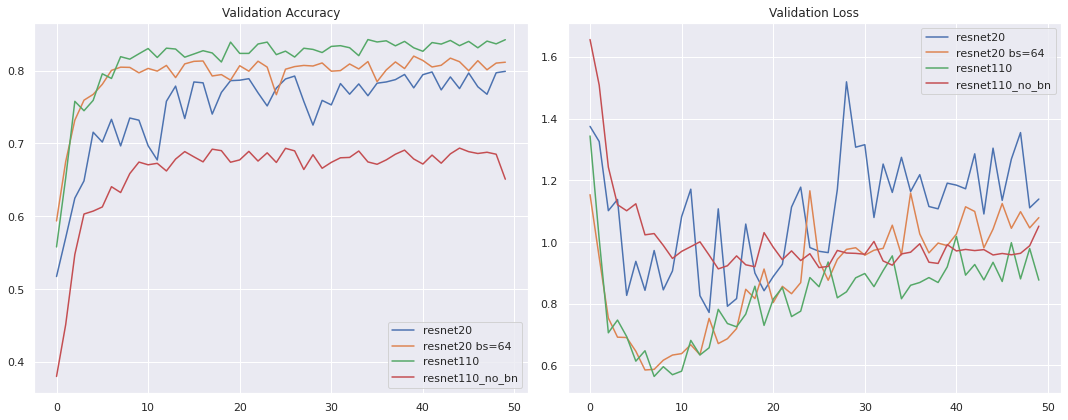

In [24]:
acc_loss_graph(accuracies, losses, ['resnet20','resnet20 bs=64', 'resnet110', 'resnet110_no_bn'])

Task 4. Evaluate ResNet models training with Dropout.

__Training models__

In [25]:
# Training Resnet20 model with Dropout (p=0.5)
accuracies['resnet20_d_out p=0.5'], losses['resnet20_d_out p=0.5'] = \
train(resnet20_d_out5(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:02:38 Accuracy: 0.42289999127388, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 20 Time: 00:05:14 Accuracy: 0.48559999465942383, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 30 Time: 00:07:51 Accuracy: 0.5555999875068665, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 40 Time: 00:10:31 Accuracy: 0.590999960899353, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 50 Time: 00:13:12 Accuracy: 0.6204000115394592, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152


In [26]:
# Training Resnet20 model with Dropout (p=0.3)
accuracies['resnet20_d_out p=0.3'], losses['resnet20_d_out p=0.3'] = \
train(resnet20_d_out3(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:02:43 Accuracy: 0.6248999834060669, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 20 Time: 00:05:28 Accuracy: 0.7221999764442444, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 30 Time: 00:08:06 Accuracy: 0.7687999606132507, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 40 Time: 00:10:44 Accuracy: 0.7947999835014343, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 50 Time: 00:13:23 Accuracy: 0.8021999597549438, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152


In [27]:
# Training Resnet20 model with Dropout (p=0.8)
accuracies['resnet20_d_out p=0.8'], losses['resnet20_d_out p=0.8'] = \
train(resnet20_d_out8(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:02:42 Accuracy: 0.22219999134540558, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 20 Time: 00:05:21 Accuracy: 0.2728999853134155, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 30 Time: 00:08:03 Accuracy: 0.2750000059604645, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 40 Time: 00:10:43 Accuracy: 0.2863999903202057, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 50 Time: 00:13:22 Accuracy: 0.29420000314712524, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152


In [28]:
# Training Resnet20 model with Dropout (p=0.15)
accuracies['resnet20_d_out p=0.15'], losses['resnet20_d_out p=0.15'] = \
train(resnet20_d_out15(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:02:42 Accuracy: 0.7685999870300293, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 20 Time: 00:05:25 Accuracy: 0.8175999522209167, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 30 Time: 00:08:05 Accuracy: 0.8348000049591064, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 40 Time: 00:10:50 Accuracy: 0.8428999781608582, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 50 Time: 00:13:36 Accuracy: 0.8452000021934509, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152


__Visualization of training__

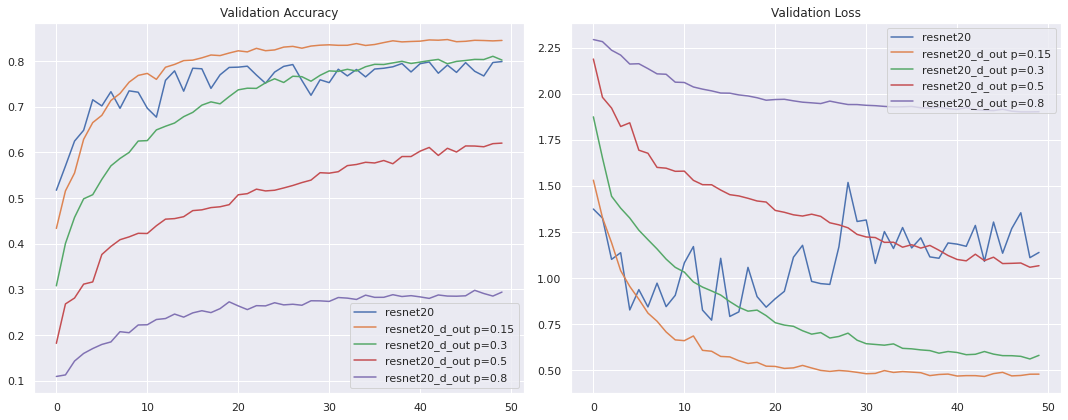

In [30]:
acc_loss_graph(accuracies, losses, ['resnet20', 'resnet20_d_out p=0.15', 'resnet20_d_out p=0.3',
                                    'resnet20_d_out p=0.5', 'resnet20_d_out p=0.8' ])

Task 5. Evaluate ResNet models training with L2-regularization.

__Training models__

In [31]:
# Training Resnet20 model with L2-regularization
accuracies['resnet20 wd=1e-5'], losses['resnet20 wd=1e-5'] = \
train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-5)

Train Epoch: 10 Time: 00:02:36 Accuracy: 0.722000002861023, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 20 Time: 00:05:13 Accuracy: 0.7389999628067017, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 30 Time: 00:07:50 Accuracy: 0.7829999923706055, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 40 Time: 00:10:27 Accuracy: 0.7657999992370605, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 50 Time: 00:13:04 Accuracy: 0.7858999967575073, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152


In [32]:
# Training Resnet20 model with L2-regularization
accuracies['resnet20 wd=1e-4'], losses['resnet20 wd=1e-4'] = \
train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-4)

Train Epoch: 10 Time: 00:02:37 Accuracy: 0.6992999911308289, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 20 Time: 00:05:14 Accuracy: 0.7522000074386597, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 30 Time: 00:07:49 Accuracy: 0.7833999991416931, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 40 Time: 00:10:19 Accuracy: 0.7858999967575073, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 50 Time: 00:12:49 Accuracy: 0.7857999801635742, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152


In [33]:
# Training Resnet20 model with L2-regularization
accuracies['resnet20 wd=1e-3'], losses['resnet20 wd=1e-3'] = \
train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-3)

Train Epoch: 10 Time: 00:02:32 Accuracy: 0.7098000049591064, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 20 Time: 00:05:09 Accuracy: 0.7356999516487122, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 30 Time: 00:07:41 Accuracy: 0.761900007724762, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 40 Time: 00:10:09 Accuracy: 0.7300999760627747, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 50 Time: 00:12:37 Accuracy: 0.7495999932289124, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152


In [34]:
# Training Resnet20 model with L2-regularization
accuracies['resnet20 wd=1e-2'], losses['resnet20 wd=1e-2'] = \
train(resnet20(), X_train, y_train, X_test, y_test, weight_decay=1e-2)

Train Epoch: 10 Time: 00:02:28 Accuracy: 0.5720999836921692, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 20 Time: 00:04:56 Accuracy: 0.686199963092804, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 30 Time: 00:07:24 Accuracy: 0.7494999766349792, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 40 Time: 00:09:52 Accuracy: 0.7263999581336975, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152
Train Epoch: 50 Time: 00:12:20 Accuracy: 0.7613999843597412, GPU_Mem_alloc: 129604096 GPU_Mem_cashed: 3934257152


__Visualization of training__

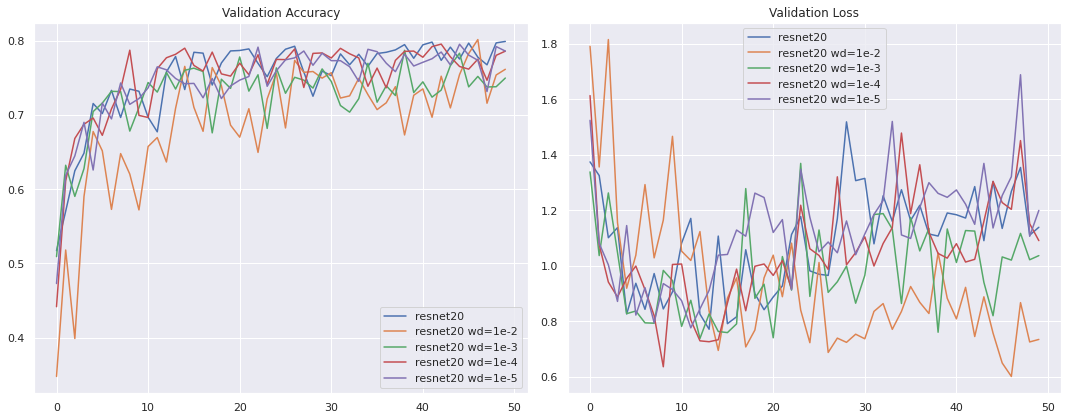

In [35]:
acc_loss_graph(accuracies, losses, ['resnet20', 'resnet20 wd=1e-2', 'resnet20 wd=1e-3',
                                    'resnet20 wd=1e-4', 'resnet20 wd=1e-5'])